## 11. GPT

## План
1. GPT from scratch
2. Transformer++
3. Стратегии декодирования
4. Constrained decoding с json

Датасет возьмём из известного репозитория Карпатого [nanoGPT](https://github.com/karpathy/nanoGPT)

In [1]:
! pip install -U datasets==2.16.0 transformers nltk sentencepiece -q

In [2]:
import requests
from datasets import load_dataset

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"

response = requests.get(url)
text = response.text

In [4]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /home/loschilov_aa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/loschilov_aa/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
sentences = sent_tokenize(' '.join(text), language='english')
train_sentences = sentences[:10000]
test_sentences = sentences[10000:]

In [6]:
len(train_sentences), len(test_sentences)

(10000, 2519)

In [7]:
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
import torch

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = self.tokenizer(self.data[idx], return_tensors = 'pt', max_length = self.max_length, truncation=True).input_ids[0]
        input_ids, labels = input_ids[:-1], input_ids[1:]
        attention_mask = torch.ones_like(input_ids, dtype=torch.bool)
        return {
            "input_ids": input_ids,
            "labels": labels,
            "attention_mask": attention_mask,
        }

In [8]:
from torch.nn.utils.rnn import pad_sequence

def data_collator(examples, padding_value=0, max_length=2048):
    def trim_and_pad(seq, batch_first=True, padding_value=0):
        return pad_sequence([s[:max_length] for s in seq], batch_first=batch_first, padding_value=padding_value)

    input_ids = trim_and_pad(
        [example["input_ids"] for example in examples],
        batch_first=True,
        padding_value=padding_value,
    )
    targets = trim_and_pad(
        [example["labels"] for example in examples],
        batch_first=True,
        padding_value=-100,
    )
    attention_mask = trim_and_pad(
        [example["attention_mask"] for example in examples],
        batch_first=True,
        padding_value=0,
    )
    return {
        "input_ids": input_ids,
        "labels": targets,
        "attention_mask": attention_mask,
    }

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.unk_token

In [10]:
from functools import partial

In [11]:
max_length = 32
train_dataset = CustomDataset(train_sentences, tokenizer, max_length=max_length)
test_dataset = CustomDataset(test_sentences, tokenizer, max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True, collate_fn=partial(data_collator, padding_value=tokenizer.pad_token_id, max_length=max_length))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False, collate_fn=partial(data_collator, padding_value=tokenizer.pad_token_id, max_length=max_length))

In [12]:
train_dataset[1]

{'input_ids': tensor([  32,  300,  300, 1058,  220,  198,  311,  279,  304,  257,  479,  837,
          220,  220,  264,  279,  304,  257,  479]),
 'labels': tensor([ 300,  300, 1058,  220,  198,  311,  279,  304,  257,  479,  837,  220,
          220,  264,  279,  304,  257,  479,  764]),
 'attention_mask': tensor([True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True])}

In [13]:
batch = next(iter(train_loader))

In [14]:
tokenizer.batch_decode(batch["input_ids"])

['l e t   t h e   V o l s c e s \n P l o u g h   R o m e',
 'C i t i z e n s : \n I t   s h a l l   b e   s o ,  ',
 'K I N G   R I C H A R D   I I I : \n S t a n l e y ,  ',
 'F R I A R   T H O M A S : \n G l a d l y ,   m y   l o',
 'O ,   n o<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 't h o u   a r t   p r e p a r i n g   f i r e   f o r',
 'B u t   w h a t   s a y   y o u   t o   T h u r s d',
 'L A R T I U S : \n S o ,   l e t   t h e   p o r t s ',
 'C L A R E N C E : \n H i s   m a j e s t y \n T e n d e r',
 'P o o r   b o y ,   t h o u   a r t   a m a z e d<|endoftext|><|endoftext|>',
 'K I N G   R I C H A R D   I I I : \n T h e n   h e  ',
 'o r   i s   i t   f e a r \n T h a t   m a k e s  ',
 

In [15]:
batch["labels"][:5]

tensor([[ 304,  256,  220,  220,  256,  289,  304,  220,  220,  569,  267,  300,
          264,  269,  304,  264,  220,  198,  350,  300,  267,  334,  308,  289,
          220,  220,  371,  267,  285,  304,  220],
        [1312,  256, 1312, 1976,  304,  299,  264, 1058,  220,  198,  314,  256,
          220,  220,  264,  289,  257,  300,  300,  220,  220,  275,  304,  220,
          220,  264,  267,  837,  220,  220, 1312],
        [ 314,  399,  402,  220,  220,  371,  314,  327,  367,  317,  371,  360,
          220,  220,  314,  314,  314, 1058,  220,  198,  311,  256,  257,  299,
          300,  304,  331,  837,  220,  220,  289],
        [ 371,  314,  317,  371,  220,  220,  309,  367,  440,  337,  317,  311,
         1058,  220,  198,  402,  300,  257,  288,  300,  331,  837,  220,  220,
          285,  331,  220,  220,  300,  267,  374],
        [ 837,  220,  220,  299,  267, 5145, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, 

In [16]:
batch["attention_mask"].sum(1)

tensor([31, 31, 31, 31,  6, 31, 31, 31, 31, 29, 31, 31, 31, 31, 31, 31, 31, 31,
        17, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 29, 21, 31, 31, 27, 12,
        31, 31, 31, 31, 31, 31, 31, 31, 31, 19, 31, 31, 31, 31, 31, 17, 31, 31,
        31, 31, 31, 31, 31, 31, 31, 31, 31, 28])

# GPT from scratch

## Positional Encoding
В оригинальном [Трансформере](https://arxiv.org/abs/1706.03762) предложили абсолютные периодические позиционные эмбеддинги:

$$\text{emb}(p, 2i) = \sin(\frac{p}{10000^{2i/d}})$$
$$\text{emb}(p, 2i + 1) = \cos(\frac{p}{10000^{2i/d}})$$
где $p, 2i, 2i+1$ - индексы элемента последовательности, $d$ - длина последовательности.
Они плохо шкалируются на длины за границей тренировочных данных, поэтому появилось много других методов, рассмотрим далее ставший стандартом [RoPE](https://arxiv.org/abs/2104.09864).

In [17]:
import torch
import torch.nn as nn
import math
from tqdm.auto import tqdm
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]) # (batch, seq_len, d_model)
        return x

## Слой аттеншена, a.k.a. One-Head Scaled Dot-Product Self-Attention

- Каждый элемент выборки $X$ - последовательность фичей $x_i \in \mathbb{R}^D$ переменной длины: $X = \{x_1, x_2, \ldots, x_{n_i}\}$
- То есть $X$ это матрица: $X \in \mathbb{R}^{n_i \times D}$
- Параметры слоя - матрицы фиксированного размера: $W_Q, W_K, W_V \in \mathbb{R}^{D \times d}$
- Вычисление:
    - $Q = X W_Q$ размера $n_i \times d_k$
    - $K = X W_K$ размера $n_i \times d_k$
    - $V = X W_V$ размера $n_i \times d_v$
- $Q, K$ можно нормализовать

## Attention это "мягкий словарь"

- `{key1: value1, key2: value2, ...}`
- **Query** - запрос на поиск среди **Key**
- Пусть $q_i$ и $k_j$ нормализованы: $\|q_i\| = \|k_j\| = 1$
- Тогда $\alpha_{ij}=\langle q_i, k_j \rangle = \cos(\theta)$, где $\theta$ - угол между $q_i$ и $k_j$, можно мерить косинусную схожесть
- Мы хотим померить релевантность всех ключей $k_j, j \in [d]$ запросу $q_i$
- Ответом на $i$-тый запрос будет вернуть линейную комбинацию всех **Value** с найденными скорами релевантности $\alpha_{ij}$

<img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/attention_example.svg" style="width:75%">


$$\text{Attention}(Q, K, V) = \operatorname{Row-Wise\ Softmax}\left(\dfrac{Q K^\top}{\sqrt{d_k}}\right) V$$   

*Почему такая нормализация?*
$$
q \sim \mathrm{N}(0, \sigma^2), k \sim \mathrm{N}(0, \sigma^2) \rightarrow \mathbb{V} \left[ \sum_{i=1}^{d_k} q_i k_i\right] = \sum_{i=1}^{d_k} \mathbb{V} \left[  q_i k_i\right] = \sum_{i=1}^{d_k} \mathbb{V}\left[  q_i\right]\mathbb{V} \left[k_i\right]= \sigma^4 d_k
$$
Стандартное отклонение будет пропорционально $\sigma \sqrt{d_k}$, отсюда нормализация.

Если мы не уменьшим дисперсию обратно до $\sigma^2$, то софтмакс по логитам уже насытится до $1$ для одного случайного элемента и $0$ для всех остальных. Градиенты через softmax затухнут, так что мы не сможем выучить параметры должным образом.

На $\sigma$ мы не масштабируем, так как при инициализации весов обычно $\sigma << 1$.

### Multi-Head Attention (MHA)
<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:75%">

- Разделяем каждый вектор из $Q, K, V$ на `num_heads` подвекторов с помощью идентичных линейных проекций $h$ раз ($D \mod h = 0$)
- Применяем Attention независимо, соединяем результаты

$$
\begin{align*}
\text{Multihead}(Q, K, V) = \textrm{concat} \left( \text{head}_1, \text{head}_2, \ldots, \text{head}_h \right) W_O,\\
\text{head}_i = \text{Attention}(Q_i, K_i, V_i), i = [h]; W_O \in \mathbb{R}^{h d_v \times d_{out}}
\end{align*}
$$
- **Можно ли написать без цикла?**

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        assert d_model % n_heads == 0, "d_model is not divisible by h"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.query = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.key = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.value = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.out = nn.Linear(d_model, d_model)
        self.scale = self.d_head ** -0.5

    def forward(self, x):
        B, L, D = x.shape
        query = self.query(x).view(B, L, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        key = self.key(x).view(B, L, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value(x).view(B, L, self.n_heads, self.d_head).permute(0, 2, 1, 3)

        dots = (query @ key.transpose(-1, -2)) * self.scale

        mask = torch.tril(torch.ones((L, L))).to(x.device)
        dots.masked_fill_(mask == 0, float('-inf'))

        att_scores = dots.softmax(-1)
        att_v = att_scores @ value

        out = att_v.permute(0, 2, 1, 3).contiguous().view(B, L, D)

        out = self.out(out)

        return out


In [19]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)

        self.MHA = MultiHeadAttention(d_model, n_heads, qkv_bias)
        self.MLP = nn.Sequential(nn.Linear(d_model, 4 * d_model), nn.ReLU(), nn.Linear(4 * d_model, d_model))

    def forward(self, x):

        x = self.layer_norm_1(self.MHA(x)) + x
        x = self.layer_norm_2(self.MLP(x)) + x

        return x


In [20]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_blocks, qkv_bias = True, seq_len = 2048):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, seq_len)
        self.blocks = nn.Sequential(*[DecoderBlock(d_model, n_heads, qkv_bias) for _ in range(n_blocks)])
        self.final_ln = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = x.to(next(iter(self.parameters())).device)
        emb = self.embedding(x)
        emb = self.pos(emb)

        x = self.blocks(emb)

        out = self.lm_head(self.final_ln(x))

        return out

In [21]:
DEVICE = "cuda:0"
D_MODEL = 512
N_HEADS = 8
VOCAB_SIZE = len(tokenizer)
N_BLOCKS = 3
mha = MultiHeadAttention(D_MODEL, N_HEADS).to(DEVICE)
decoder_block = DecoderBlock(D_MODEL, N_HEADS).to(DEVICE)
model = TransformerDecoder(VOCAB_SIZE, D_MODEL, N_HEADS, N_BLOCKS).to(DEVICE).to(DEVICE)

In [22]:
loss_fnc = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [23]:
from tqdm.auto import tqdm
import numpy as np

In [24]:
loss_epochs = []
loss_evals = []
for epoch in tqdm(range(10)):
    loss_epoch = []
    model.train()
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(DEVICE)
        labels_ids = batch["labels"].to(DEVICE)

        preds = model(input_ids)

        optimizer.zero_grad()
        loss = loss_fnc(preds.view(-1, preds.size(-1)), labels_ids.view(-1))
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())

    loss_eval = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch["input_ids"].to(DEVICE)
            labels_ids = batch["labels"].to(DEVICE)

            preds = model(input_ids)

            loss = loss_fnc(preds.view(-1, preds.size(-1)), labels_ids.view(-1))
            loss_eval.append(loss.item())

    print(f'Loss_epoch {epoch + 1}: {np.mean(loss_epoch)}')
    print(f'Loss_eval {epoch + 1}: {np.mean(loss_eval)}')
    loss_epochs.append(np.mean(loss_epoch))
    loss_evals.append(np.mean(loss_eval))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 1: 2.1734787286466855
Loss_eval 1: 1.8844347715377807


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 2: 1.4413372346550037
Loss_eval 2: 1.9330095261335374


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 3: 1.3487798977809347
Loss_eval 3: 1.8421268582344055


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 4: 1.3084732468720455
Loss_eval 4: 1.8425840795040132


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 5: 1.2668128173062756
Loss_eval 5: 1.867698785662651


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 6: 1.2106073935320423
Loss_eval 6: 1.8428018867969513


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 7: 1.1721860132399637
Loss_eval 7: 1.8175002753734588


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 8: 1.1674535684524827
Loss_eval 8: 1.8450906962156295


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 9: 1.1609998964200354
Loss_eval 9: 1.7842959880828857


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss_epoch 10: 1.1937230225581272
Loss_eval 10: 1.8413215219974517


In [25]:
import matplotlib.pyplot as plt

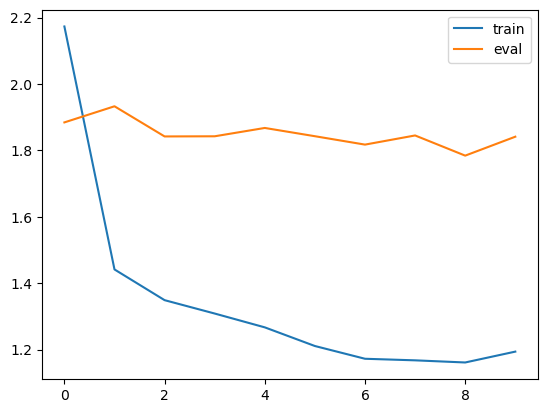

In [26]:
plt.plot(loss_epochs, label="train")
plt.plot(loss_evals, label="eval")
plt.legend()
plt.show()

In [27]:
batch = train_dataset[3]
input_ids, labels_ids = batch["input_ids"], batch["labels"]

In [28]:
@torch.no_grad()
def generate_batch(model, ids, is_decode = False, max_length = 20):

    model.eval()
    if type(ids) == list:
        symbols = torch.tensor(ids, device = DEVICE).view(len(ids),1)

    else:
        symbols = torch.tensor(ids, device = DEVICE).view(1,1)

    for _ in range(max_length - 1):

        cur_symbols = model(symbols).argmax(-1)[:, -1][:, None]
        symbols = torch.cat([symbols, cur_symbols], dim = 1)

    if is_decode:
        symbols = tokenizer.batch_decode(symbols, skip_special_tokens=True)
    return symbols

In [29]:
generate_batch(model, ids = input_ids[0].item(), is_decode=True, max_length= 30)

['A n d   I   t h e   c o m e   t h e   s o u l d ']

In [30]:
tokenizer.decode(labels_ids, skip_special_tokens=True)

' l l : \n R e s o l v e d .'

# Transformer++

## RMSNorm
Первое архитектурное нововведение - исключение обучаемого `bias` из нормализации. Делает обучение быстрее и стабильнее благодаря своей простоте

In [31]:
class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)

    def extra_repr(self):
        return f"{tuple(self.weight.shape)}, eps={self.variance_epsilon}"

## RoPE
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-08-10_at_10.38.41_AM.png" style="width:75%">

RoPE (Rotary Position Embedding) — это способ кодирования позиционной информации в трансформерах, который использует вращательные преобразования для улучшения моделирования отношений между токенами. Вместо прибавления позиционных эмбеддингов к токенам, RoPE вращает их, учитывая относительную позицию токенов в последовательности. Для пары токенов $x_i, x_j$ фазовая разница учитывается напрямую через скалярное произведение, сохраняя относительное расположение токенов:

$$
\operatorname{RoPE}(x) = \begin{bmatrix} x^{(1)} \cos \theta - x^{(2)} \sin \theta \\ x^{(1)} \sin \theta + x^{(2)} \cos \theta \end{bmatrix},
$$


где $\theta=\text{freq}(i)$ определяется в зависимости от позиции $i$ и масштабируется для каждой частоты. Такой подход позволяет трансформеру эффективно обрабатывать как локальные, так и дальние зависимости, улучшая качество на задачах с длинным контекстом.

In [32]:
from typing import Optional, Tuple
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    """
    Precompute the frequency tensor for complex exponentials (cis) with given dimensions.

    This function calculates a frequency tensor with complex exponentials using the given dimension 'dim'
    and the end index 'end'. The 'theta' parameter scales the frequencies.
    The returned tensor contains complex values in complex64 data type.

    Args:
        dim (int): Dimension of the frequency tensor.
        end (int): End index for precomputing frequencies.
        theta (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.

    Returns:
        torch.Tensor: Precomputed frequency tensor with complex exponentials.

    """
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    """
    Reshape frequency tensor for broadcasting it with another tensor.

    This function reshapes the frequency tensor to have the same shape as the target tensor 'x'
    for the purpose of broadcasting the frequency tensor during element-wise operations.

    Args:
        freqs_cis (torch.Tensor): Frequency tensor to be reshaped.
        x (torch.Tensor): Target tensor for broadcasting compatibility.

    Returns:
        torch.Tensor: Reshaped frequency tensor.

    Raises:
        AssertionError: If the frequency tensor doesn't match the expected shape.
        AssertionError: If the target tensor 'x' doesn't have the expected number of dimensions.
    """
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1]), f'{freqs_cis.shape} - {(x.shape[1], x.shape[-1])}'
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply rotary embeddings to input tensors using the given frequency tensor.

    This function applies rotary embeddings to the given query 'xq' and key 'xk' tensors using the provided
    frequency tensor 'freqs_cis'. The input tensors are reshaped as complex numbers, and the frequency tensor
    is reshaped for broadcasting compatibility. The resulting tensors contain rotary embeddings and are
    returned as real tensors.

    Args:
        xq (torch.Tensor): Query tensor to apply rotary embeddings.
        xk (torch.Tensor): Key tensor to apply rotary embeddings.
        freqs_cis (torch.Tensor): Precomputed frequency tensor for complex exponentials.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tuple of modified query tensor and key tensor with rotary embeddings.
    """
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [33]:
class MultiHeadAttentionRoPE(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        assert d_model % n_heads == 0, "d_model is not divisible by h"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.query = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.key = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.value = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.out = nn.Linear(d_model, d_model)
        self.scale = self.d_head ** -0.5

    def forward(self, x):
        B, L, D = x.shape
        query = self.query(x).view(B, L, self.n_heads, self.d_head)
        key = self.key(x).view(B, L, self.n_heads, self.d_head)
        value = self.value(x).view(B, L, self.n_heads, self.d_head).transpose(1,2)
        query, key = apply_rotary_emb(query, key, precompute_freqs_cis(self.d_head, 4096)[:L].to(next(iter(self.query.parameters())).device))
        query = query.transpose(1,2)
        key = key.transpose(1,2)

        dots = (query @ key.transpose(-1, -2)) * self.scale

        mask = torch.tril(torch.ones((L, L))).to(x.device)
        dots.masked_fill_(mask == 0, float('-inf'))

        att_scores = dots.softmax(-1)
        att_v = att_scores @ value

        out = att_v.permute(0, 2, 1, 3).contiguous().view(B, L, D)

        out = self.out(out)

        return out


In [34]:
class FeedForwardLlama(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.w1 = nn.Linear(d_model, 4 * d_model)
        self.w2 = nn.Linear(4 * d_model, d_model)
        self.w3 = nn.Linear(d_model, 4 * d_model)

    def forward(self, x):
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

In [35]:
class DecoderBlockLlama(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        self.RMSNorm_1 = RMSNorm(d_model)
        self.RMSNorm_2 = RMSNorm(d_model)

        self.MHA = MultiHeadAttentionRoPE(d_model, n_heads, qkv_bias)
        self.MLP = FeedForwardLlama(d_model)

    def forward(self, x):

        x = self.MHA(self.RMSNorm_1(x)) + x
        x = self.MLP(self.RMSNorm_2(x)) + x

        return x


In [36]:
class TransformerDecoderLlama(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_blocks, qkv_bias = True, seq_len = 2048):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.blocks = nn.Sequential(*[DecoderBlockLlama(d_model, n_heads, qkv_bias) for _ in range(n_blocks)])
        self.final_ln = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = x.to(next(iter(self.parameters())).device)
        emb = self.embedding(x)

        x = self.blocks(emb)

        out = self.lm_head(self.final_ln(x))

        return out

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
D_MODEL = 256
N_HEADS = 8
VOCAB_SIZE = len(tokenizer)
N_BLOCKS = 3
model_llama = TransformerDecoderLlama(VOCAB_SIZE, D_MODEL, N_HEADS, N_BLOCKS).to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [38]:
loss_fnc = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_llama.parameters(), lr=1e-3)

NameError: name 'model_llama' is not defined

In [ ]:
model_llama.train()
loss_epochs = []
for epoch in tqdm(range(10)):
    loss_epoch = []
    for input_ids, labels_ids, data_attention_mask in tqdm(train_loader):
        input_ids = input_ids.to(DEVICE)
        labels_ids = labels_ids.to(DEVICE)
        data_attention_mask = data_attention_mask.to(DEVICE)

        preds = model_llama(input_ids)
        preds = preds[data_attention_mask]
        labels_ids = labels_ids[data_attention_mask]

        optimizer.zero_grad()
        loss = loss_fnc(preds, labels_ids)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())

    print(f'Loss_epoch {epoch + 1}: {np.mean(loss_epoch)}')
    loss_epochs.append(np.mean(loss_epoch))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 1: 6.194635764808412


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 2: 4.738284022944748


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 3: 4.250940720746471


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 4: 3.8585795551348645


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 5: 3.4588485827111892


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 6: 3.02666294802526


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 7: 2.567799759518569


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 8: 2.116686393500893


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 9: 1.7056092449054596


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 10: 1.3614490647224864


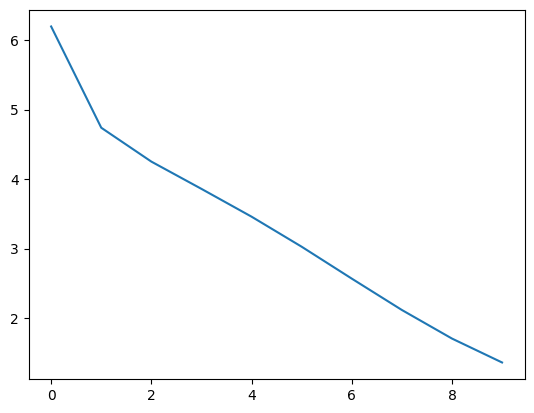

In [ ]:
plt.plot(loss_epochs)

In [ ]:
input_ids, labels_ids, data_attention_mask = train_dataset[2]

In [ ]:
@torch.no_grad()
def generate_batch(model, symbols, is_decode = False, max_length = 20):

    model.eval()
    # if type(ids) == list:
    #     symbols = torch.tensor(ids, device = DEVICE).view(len(ids),1)

    # else:
    #     symbols = torch.tensor(ids, device = DEVICE).view(1,1)

    for _ in range(max_length - 1):

        cur_symbols = model(symbols).argmax(-1)[:, -1][:, None]
        symbols = torch.cat([symbols, cur_symbols], dim = 1)

    if is_decode:
        symbols = tokenizer.batch_decode(symbols, skip_special_tokens=True)
    return symbols

In [ ]:
generate_batch(model_llama, input_ids[:2].view(1, -1).to(DEVICE), is_decode=True, max_length= 28)

['First Citizen: He has our voices, sir. strange one of us?--I know not--but,-- CAMILLO, but are']

In [ ]:
tokenizer.decode(input_ids, skip_special_tokens=True)

'First Citizen: You are all resolved rather to die than to famish?'

In [ ]:
num = 0

for p in model.parameters():
  num+= p.numel()
num

60970577

In [ ]:
num = 0

for p in model_llama.parameters():
  num+= p.numel()
num

26834513

# Стратегии декодирования

В последние годы растет интерес к языковой генерации благодаря появлению больших языковых моделей на основе трансформеров, обучаемых на миллионах веб-страниц, таких как знаменитая OpenAI [GPT2 model](https://openai.com/blog/better-language-models/). Результаты впечатляют, e.g. [GPT2 on unicorns](https://openai.com/blog/better-language-models/#samples), [XLNet](https://medium.com/@amanrusia/xlnet-speaks-comparison-to-gpt-2-ea1a4e9ba39e), [Controlled language with CTRL](https://blog.einstein.ai/introducing-a-conditional-transformer-language-model-for-controllable-generation/). Помимо улучшенной архитектуры transformer и большого объема обучающих данных, важную роль также сыграли улучшенные методы декодирования.

В этом блокноте дается краткий обзор различных стратегий декодирования и, что более важно, показано, как * вы * можете реализовать их с минимальными усилиями, используя популярную библиотеку `transformers`!

Все следующие функциональные возможности могут быть использованы для **авторегрессионной** генерации языка ([тут](http://jalammar.github.io/illustrated-gpt2/) как это делается). Если коротко, *авторегрессионная* генерация языка основана на предположении, что распределение вероятностей последовательности слов может быть разложено на произведение следующих условных вероятностей:
$$ P(w_{1:T} | W_0 ) = \prod_{t=1}^T P(w_{t} | w_{1: t-1}, W_0) \text{ ,with }  w_{1: 0} = \emptyset, $$


Авторегрессивная генерация языка теперь доступна для `GPT2`, `XLNet`, `OpenAi-GPT`, `CTRL`, `TransfoXL`, `XLM`, `Bart`, `T5`!

Мы проведем экскурсию по наиболее известным в настоящее время методам декодирования, главным образом *Greedy search*, *Beam search*, *Top-K sampling*  и *Top-p sampling*.


In [ ]:
! pip install transformers -q

In [ ]:
import torch

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# B x seq_len x vocab_size

### **Greedy Search**

Жадный поиск просто выбирает слово с наибольшей вероятностью в качестве следующего слова: $w_t = argmax_{w}P(w | w_{1:t-1})$ на каждом временном шаге $t$. На следующем рисунке показан Greedy Search.

![Greedy Search](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/greedy_search.png)

Начиная со слова $\text{"The"}$, алгоритм
жадно выбирает следующее слово с наибольшей вероятностью $\text{"nice"}$ и так далее, так что конечная сгенерированная последовательность слов будет $\text{"The", "nice", "woman"}$ с общей вероятностью $0.5 \times 0.4 = 0.2$.

В дальнейшем мы будем генерировать последовательности слов, используя GPT2 в контексте $(\text{"I", "enjoy", "walking", "with", "my", "cute", "dog"})$. Давайте посмотрим, как можно использовать жадный поиск в "трансформерах" следующим образом
:

In [ ]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='pt')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure if I'll


Хорошо! Мы сгенерировали наш первый короткий текст с помощью GPT2 😊. Сгенерированные слова, следующие контексту, разумны, но модель быстро начинает повторяться! Это очень распространенная проблема при генерации языка в целом и, по-видимому, еще более распространена при grid / beam search'e - проверьте [Vijayakumar et al., 2016](https://arxiv.org/abs/1610.02424) and [Shao et al., 2017](https://arxiv.org/abs/1701.03185).

Однако основным недостатком жадного поиска является то, что он пропускает слова с высокой вероятностью, скрытые за словом с низкой вероятностью, как видно из нашего наброска выше:

Слово $\text{"has"}$ с его высокой условной вероятностью $0,9$ скрыто за словом $\text{"dog"}$, которое имеет только вторую по величине условную вероятность, так что жадный поиск пропускает последовательность слов $\text{"The"}, \text{"dog"}, \text{"has"}$.

К счастью, у нас есть beam search, чтобы решить эту проблему!


### **Beam search**

Поиск по лучу (beam search) снижает риск пропуска скрытых последовательностей слов с высокой вероятностью, сохраняя наиболее вероятные "num_beams" гипотез на каждом временном шаге и в конечном итоге выбирая гипотезу, имеющую в целом наибольшую вероятность. Давайте проиллюстрируем это с помощью `num_beams=2`:

![Beam search](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/beam_search.png)

На временном шаге $1$, помимо наиболее вероятной гипотезы $\text{"The", "woman"}$, beam search также отслеживает вторую наиболее вероятную гипотезу $\text{"The", "dog"}$. На временном шаге $2$ поиск по лучу обнаруживает, что последовательность слов $\text{"The", "dog", "has"}$ имеет вероятность $0,36$ более высокую, чем $\text{"The", "nice", "woman"}$, которая имеет $0,2$. Отлично, он нашел наиболее вероятную последовательность слов в нашем примере!

Поиск по лучу всегда найдет выходную последовательность с большей вероятностью, чем жадный поиск, но не гарантирует нахождения наиболее вероятного результата.

Давайте посмотрим, как поиск по лучу можно использовать в "трансформерах". Мы устанавливаем `num_beams > 1` и `early_stopping=True`, чтобы генерация завершалась, когда все гипотезы луча достигали токена EOS.

In [ ]:
# activate beam search and early_stopping
beam_output = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm not sure if I'll ever be able to walk with him again. I'm not sure if I'll


Хотя результат, возможно, более плавный, выход по-прежнему включает повторения одних и тех же последовательностей слов.  
Простое решение состоит в том, чтобы ввести штрафы за *n-граммы* (*также известные как последовательности слов из $n$ слов), как это было введено [Paulus et al. (2017)](https://arxiv.org/abs/1705.04304 ) и [Klein et al. (2017)](https://arxiv.org/abs/1701.02810 ). Наиболее распространенный штраф *n-граммов* гарантирует, что ни один *n-грамм* не появится дважды, вручную устанавливая вероятность следующих слов, которые могли бы создать уже встречавшийся *n-грамм*, равной $0$.

Давайте попробуем это, установив `no_repeat_n_gram_size=2`, чтобы ни один биграм не появлялся дважды:

In [ ]:
# set no_repeat_ngram_size to 2
beam_output = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=1,
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if it's a good idea for me to go out and play in the park. If you're going on an errand or something like that (which is probably fine), don't


Мило, это выглядит намного лучше! Мы можем видеть, что повторение больше не появляется. Тем не менее, *n-граммовые* штрафы следует использовать с осторожностью. В статье, сгенерированной о городе *Нью-Йорк*, не следует использовать штраф в размере *2-gramms* или название города будет встречаться только один раз во всем тексте!

Еще одной важной особенностью поиска луча является то, что мы можем сравнить верхние лучи после генерации и выбрать сгенерированный луч, который лучше всего соответствует нашей цели.

В `transformers` мы просто устанавливаем параметр `num_return_sequences` на количество лучей с наибольшим количеством баллов, которые должны быть возвращены. Убедитесь, однако, что `num_return_sequences <= num_beams`!

In [ ]:
# set return_num_sequences > 1
beam_outputs = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True
)

# now we have 3 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}\n".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to take a break

1: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to get back to

2: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with her again.

I've been thinking about this for a while now, and I think it's time for me to take a break

3: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with her again.

I've been thinking about this for a while now, and I think it's time for me to get back to

4: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking ab

## Sampling

В своей самой простой форме sampling означает случайный выбор следующего слова $w_t$ в соответствии с его условным распределением вероятностей:

$$w_t \sim P(w|w_{1:t-1})$$

Используя приведенный выше пример, на следующем рисунке визуализируется генерация языка при выборке.

![vanilla_sampling](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/sampling_search.png)

Становится очевидным, что генерация языка с использованием sampling больше не является "детерминированной". Cлово
$\text{"car"}$ выбирается из условного распределения вероятностей $P(w |\text{"The"})$, за которым следует sampling $\text{"drives"}$ из $P(w |\text{"The"}, \text{"car"})$.

В `transformers` устанавливаем `do_sample=True` и деактивируем sampling *Top-K* (подробнее об этом позже) через `top_k=0`. Не стесняйтесь изменять `random_seed`, чтобы поиграть с моделью.

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.random.manual_seed(1)

# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog when there are other people around, though.

No, ladies, enjoying your dog and publicly embracing her is not my thing. It doesn't even bother me, woman-like. I'm happy you think


Интересно! Текст кажется нормальным, но при ближайшем рассмотрении оказывается, что он не очень связный. Слова *new hand sense* и *local batte harness* очень странные и звучат не так, как будто они были написаны человеком. Это большая проблема при выборке последовательностей слов: модели часто генерируют бессвязную тарабарщину, *ср.* [Ари Хольцман и др. (2019)](https://arxiv.org/abs/1904.09751 ).

Хитрость заключается в том, чтобы сделать распределение $P(w|w_{1:t-1})$ более четким (увеличивая вероятность слов с высокой вероятностью и уменьшая вероятность слов с низкой вероятностью), понизив так называемую "температуру" [softmax](https://en.wikipedia.org/wiki/Softmax_function#Smooth_arg_max ).

$q = \frac{exp(z_i / T)}{\sum_j exp(z_j / T)}$

Иллюстрация применения температуры к нашему примеру, приведенному выше, может выглядеть следующим образом.

![top_p_sampling](https://github.com/patrickvonplaten/scientific_images/blob/master/sampling_search_with_temp.png?raw=true)

Условное распределение следующего слова на шаге $t = 1$ становится намного более четким, практически не оставляя шансов для выбора слова $\text{"car"}$.


In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.random.manual_seed(0)

# use temperature to decrease the sensitivity to low probability candidates
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=0,
    temperature=0.7
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog," she said. "He has a lot of aggression and eventually gets aggressive and starts barking at you. So I just make sure I'm smart enough to find a safe place to stop and look for him. It


## **Top-K Sampling**

[Fan et. al (2018)](https://arxiv.org/pdf/1805.04833.pdf ) ввел простую, но очень мощную схему семплирования, называемую выборкой ***Top-K***. В выборке *Top-K* фильтруются *K* наиболее вероятных следующих слов, и масса вероятности перераспределяется только между этими *K* следующими словами.
GPT2 принял эту схему семплирования, что стало одной из причин его успеха.

Мы расширили диапазон слов, используемых для обоих этапов семплирования в приведенном выше примере, с 3 слов до 10 слов, чтобы лучше проиллюстрировать выборку *Top-K*.

![top_k_sampling](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/top_k_sampling.png)

Установив $K = 6$, на обоих этапах семплирования мы ограничиваем наш пул выборок 6 словами. В то время как 6 наиболее вероятных слов, определенных как $V_ {\text{top-K}}$, охватывают только *около* двух третей всей массы вероятности на первом шаге, они включают почти всю массу вероятности на втором шаге. Тем не менее, мы видим, что он успешно устраняет довольно странных кандидатов $\text{"not", "the", "small", "told"}$
на втором этапе отбора проб.


Давайте посмотрим, как *Top-K* можно использовать в библиотеке, установив `top_k=50`:


In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.random.manual_seed(0)

# set top_k to 50
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_p=0.9
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog," she says. "You get a lot of love and support from people you can't really talk to because you don't know why and it doesn't help much. We'd say to her 'Do you have


Совсем неплохо! Этот текст, пожалуй, самый "человечный" на сегодняшний день.
Однако одна проблема с выборкой *Top-K* заключается в том, что она динамически не адаптирует количество слов, которые отфильтровываются из распределения вероятности следующего слова $P (w |w_ {1:t-1})$.
Это может быть проблематично, поскольку некоторые слова могут быть выбраны из очень четкого распределения (распределение справа на графике выше), в то время как другие - из гораздо более плоского распределения (распределение слева на графике выше).

На шаге $t=1$, *Top-K* исключает возможность
примеров $\text{"people", "big", "house", "cat"}$, которые кажутся разумными кандидатами. С другой стороны, на шаге $t= 2$ метод включает, возможно, неправильно подобранные слова $\text{"down", "a"}$ в выборку слов. Таким образом, ограничение пула выборок фиксированным размером *K* может привести к тому, что модель будет выдавать тарабарщину для четких распределений и ограничит творческий потенциал модели для плоского распределения.
Эта интуиция привела [Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751 ) для создания ***Top-p*** - или ***nucleus***-sampling.

## **Sampling Top-p (nucleus)**

Вместо выборки только из наиболее вероятных *K* слов, в выборке *Top-p* выбирается из наименьшего возможного набора слов, совокупная вероятность которых превышает вероятность *p*. Затем масса вероятности перераспределяется между этим набором слов. Таким образом, размер набора слов (количество слов в наборе) может динамически увеличиваться и уменьшаться в соответствии с распределением вероятности следующего слова. Ладно, это было очень многословно, давайте визуализируем.

![top_p_sampling](https://github.com/patrickvonplaten/scientific_images/blob/master/top_p_sampling.png?raw=true)

Установив $p=0.92$, выборка *Top-p* выбирает *минимальное* количество слов, которое в совокупности должно превышать $p=92\%$ от массы вероятности, определяемой как $V_{\text{top-p}}$. В первом примере это включало 9 наиболее вероятных слов, тогда как во втором примере нужно выбрать только 3 лучших слова, чтобы их вероятностная масса превысила 92%. На самом деле все очень просто! Можно видеть, что стратегия сохраняет широкий диапазон слов, где следующее слово, возможно, менее предсказуемо, *например* $P(w | \text{"The"})$, и только несколько слов, когда следующее слово кажется более предсказуемым, *например* $P(w | \text{"The", "car"})$.

Мы активируем выборку *Top-p*, установив `0 < top_p < 1`:

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.random.manual_seed(3)

# deactivate top_k sampling and sample only from 92% most likely words
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_p=0.8,
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog and traveling, and I'm a former Army Air Marshal. After graduating from Johns Hopkins in 2010, I was sent to duty for 10 years as an artillery sergeant. This was in the pre-9/11 period


Отлично, звучит так, словно это мог бы написать человек. Ну, может быть, еще не совсем.

Хотя в теории *Top-p* кажется более элегантным, чем *Top-K*, оба метода хорошо работают на практике. *Top-p* также можно использовать в сочетании с *Top-K*, что позволяет избежать слов с очень низким скором, обеспечивая при этом некоторый динамический выбор.

Наконец, чтобы получить несколько независимо отобранных выходных данных, мы можем установить параметр `num_return_sequences > 1`:

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.random.manual_seed(0)

# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=50,
    top_p=0.95,
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog," she says. "You get a lot of love and support out of it. It has helped me to be open and see what's really cool. I'm happy to see people are supporting my cause and just
1: I enjoy walking with my cute dog. I would also like to see a new feature for our cats, the cute bear, that is called 'Spend Your Sunday, Beating Dogs, by Feeding Dogs'.

Please see our page for
2: I enjoy walking with my cute dog, but I would definitely encourage anyone that will play around with your dog's ears to use a bit of patience and patience.

The dog's ears should be removed right away. After they are gone from the


## Constrained generation

Для лучшей читаемости мы будем использовать end-of-line в качестве токена EOS, вместо того, чтобы просто всегда генерировать 50 токенов.

In [ ]:
END_OF_LINE = tokenizer('\n').input_ids[0]
print(END_OF_LINE)

198


Поиск по базовому лучу выдает очень похожие предложения; все они содержат "not sure" или "don't think".

In [ ]:
beam_outputs = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True,
    eos_token_id=END_OF_LINE,
)

print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

1: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with her again.

2: I enjoy walking with my cute dog, but I don't think I'll ever be able to walk with her again.

3: I enjoy walking with my cute dog, but I don't think I'll ever be able to walk with him again.

4: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again. I don't know what to do.



Что произойдет, если мы запретим модели использовать эти фразы?



In [ ]:
beam_outputs = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True,
    eos_token_id=END_OF_LINE,
    bad_words_ids=tokenizer(['sure', 'think', 'thundersnatch'], add_prefix_space=True)['input_ids'],
)

print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog, but I don't want to have to go through the hassle of going to the vet to get a new dog.

1: I enjoy walking with my cute dog, but I don't want to have to go through the hassle of going to the vet to get a new one.

2: I enjoy walking with my cute dog, but I don't want to have to go through the hassle of going to the vet to see if my dog is sick.

3: I enjoy walking with my cute dog, but I don't want to have to go through the hassle of going to the vet.

4: I enjoy walking with my cute dog, but I don't like to walk alone.



In [ ]:
tokenizer(['sure', ' sure', ' I am not sure'])['input_ids']

[[19532], [1654], [314, 716, 407, 1654]]

Мы видим, что смысл этих текстов сильно изменился – но каким-то непредсказуемым образом.

Можем ли мы заставить модель написать текст с участием "cat"?

In [ ]:
beam_outputs = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True,
    eos_token_id=END_OF_LINE,
    bad_words_ids=tokenizer(['sure', 'think'], add_prefix_space=True)['input_ids'],
    force_words_ids=[tokenizer(['cat'], add_prefix_space=True, add_special_tokens=False).input_ids],
)

print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog, but I'm not a big fan of dogs that are too big for me," she said. "I like to have a little bit of space for my dogs, and I don't want them to be too
1: I enjoy walking with my cute dog, but I'm not a big fan of dogs that are too big for me," she said. "I like to have a little bit of space for my dogs, and I don't want them to get too
2: I enjoy walking with my cute dog, but I'm not a big fan of dogs that are too big for me," she said. "I like to have a little bit of space for my dogs, and I don't want them to get in
3: I enjoy walking with my cute dog, but I'm not a big fan of dogs that are too big for me," she said. "I like to have a little bit of space for my dogs, and I don't want them to be cat
4: I enjoy walking with my cute dog, but I'm not a big fan of dogs that are too big for me," she said. "I like to have a little bit of space for m

Уточнение: **force_words_ids** - это список ограничений. Каждое ограничение представляет собой список выражений, таких, что по крайней мере одно выражение должно быть включено в сгенерированный текст. И каждое выражение - это просто список токенов.

Смотрите обсуждение в [the HF pull request](https://github.com/huggingface/transformers/issues/14081 ), или прочтите статью "[Guided Generation of Cause and Effect](https://www.ijcai.org/proceedings/2020/0502.pdf )" Ли и др., где был предложен алгоритм.  

Чтобы оценить силу этих ограничений, давайте заставим модель включить мышь (или даже много мышей) в текст. Мы также можем ослабить ограничение "кошка", разрешив вместо него использовать слова "кошки", "котенок" или "кошачий".

In [ ]:
beam_outputs = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True,
    eos_token_id=END_OF_LINE,
    bad_words_ids=tokenizer(['sure', 'think'], add_prefix_space=True)['input_ids'],
    force_words_ids = [
        tokenizer(['cat', 'cats', 'kitten', 'feline', 'Cat', 'Cats'], add_prefix_space=True, add_special_tokens=False).input_ids,
        tokenizer(['mouse', 'mice'], add_prefix_space=True, add_special_tokens=False).input_ids,
    ],
)

print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog. I love to play with her and she loves to be with me. She loves being with us and I'm happy to have her around. We have a great time together and we have fun together. It's
1: I enjoy walking with my cute dog. I love to play with her and she loves to be with me. She loves being with us and I'm happy to have her around. We have a great time together and we have fun together. It f
2: I enjoy walking with my cute dog. I love to play with her and she loves to be with me. She loves being with us and I'm happy to have her around. We have a great time together and we have fun together. It cat
3: I enjoy walking with my cute dog. I love to play with her and she loves to be with me. She loves being with us and I'm happy to have her around. We have a great time together and we have fun together. Cats mice
4: I enjoy walking with my cute dog. I love to p

## **Заключение**

Методы декодирования *ad-hoc*, выборка *top-p* и *top-K*, по-видимому, обеспечивают более плавный текст, чем традиционный *жадный* и *лучевой* поиск при генерации открытого языка.
Однако в последнее время появилось больше доказательств того, что очевидные недостатки *жадного* и *лучевого* поиска - в основном генерирующие повторяющиеся последовательности слов - вызваны моделью (особенно способом обучения модели), а не методом декодирования,  [Уэллек и др. (2019)](https://arxiv.org/pdf/1908.04319.pdf ). Кроме того, как показано в [Welleck et al. (2020)](https://arxiv.org/abs/2002.02492 ), похоже, что выборки *top-K* и *top-p* также страдают от генерации повторяющихся последовательностей слов.

В [Welleck et al. (2019)](https://arxiv.org/pdf/1908.04319.pdf ), авторы показывают, что, согласно человеческим оценкам, лучевой поиск может генерировать более плавный текст, чем выборка *Top-p*, при адаптации цели обучения модели.

## **Приложение**

Есть пара дополнительных параметров для метода `generate`, которые не были упомянуты выше. Мы кратко объясним их здесь!

- `min_length` можно использовать, чтобы заставить модель не выдавать токен EOS (= не заканчивать предложение) до достижения `min_length`. Это довольно часто используется при суммаризации, но может быть полезно в целом, если пользователь хочет получить более длинные выходные данные.
- `repetition_penalty` может использоваться для "наказания" слов, которые уже были сгенерированы или принадлежат контексту. Впервые он был представлен [Kesker et al. (2019)](https://arxiv.org/abs/1909.05858 ) и также используется в цели обучения в [Welleck et al. (2019)](https://arxiv.org/pdf/1908.04319.pdf ). Это может быть довольно эффективно для предотвращения повторений, но, по-видимому, очень чувствительно к различным моделям и вариантам использования, *например* смотрите это [обсуждение](https://github.com/huggingface/transformers/pull/2303 ) на Github.

- `attention_mask` можно использовать для маскировки дополненных токенов
- `pad_token_id`, `bos_token_id`, `eos_token_id`: Если в модели по умолчанию нет этих токенов, пользователь может вручную выбрать другие идентификаторы токенов для их представления.


In [ ]:
!pip install vllm lm-format-enforcer triton -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.4 MB/s eta 0:00:00


We load the model, as is normally done with vLLM

In [ ]:
import torch

In [ ]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

model_id = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

llm = LLM(model=model_id, dtype=torch.float16)


WARNING 11-29 14:58:18 config.py:1865] Casting torch.bfloat16 to torch.float16.
INFO 11-29 14:58:18 config.py:350] This model supports multiple tasks: {'generate', 'embedding'}. Defaulting to 'generate'.
INFO 11-29 14:58:18 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='HuggingFaceTB/SmolLM2-1.7B-Instruct', speculative_config=None, tokenizer='HuggingFaceTB/SmolLM2-1.7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_ti

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

INFO 11-29 14:59:41 weight_utils.py:288] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 11-29 14:59:48 model_runner.py:1077] Loading model weights took 3.1887 GB
INFO 11-29 14:59:51 worker.py:232] Memory profiling results: total_gpu_memory=14.75GiB initial_memory_usage=3.35GiB peak_torch_memory=3.67GiB memory_usage_post_profile=3.38GiB non_torch_memory=0.19GiB kv_cache_size=9.41GiB gpu_memory_utilization=0.90
INFO 11-29 14:59:52 gpu_executor.py:113] # GPU blocks: 3212, # CPU blocks: 1365
INFO 11-29 14:59:52 gpu_executor.py:117] Maximum concurrency for 8192 tokens per request: 6.27x
INFO 11-29 14:59:58 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-29 14:59:58 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-

In [ ]:
from IPython.display import display, Markdown

def display_header(text):
    display(Markdown(f'**{text}**'))

def display_content(text):
    display(Markdown(f'```\n{text}\n```'))

## Скомбинируем CharacterLevelParser с vLLM

In [ ]:
from lmformatenforcer import CharacterLevelParser
from lmformatenforcer.integrations.vllm import build_vllm_logits_processor, build_vllm_token_enforcer_tokenizer_data
from typing import Union, List, Optional
from vllm import SamplingParams

DEFAULT_MAX_NEW_TOKENS = 100

ListOrStrList = Union[str, List[str]]

tokenizer_data = build_vllm_token_enforcer_tokenizer_data(llm)

def vllm_with_character_level_parser(prompt: ListOrStrList, parser: Optional[CharacterLevelParser] = None) -> ListOrStrList:
    sampling_params = SamplingParams()
    sampling_params.max_tokens = DEFAULT_MAX_NEW_TOKENS
    if parser:
        logits_processor = build_vllm_logits_processor(tokenizer_data, parser)
        sampling_params.logits_processors = [logits_processor]
    results = llm.generate(prompt, sampling_params=sampling_params)
    if isinstance(prompt, str):
        return results[0].outputs[0].text
    else:
        return [result.outputs[0].text for result in results]


## vLLM + JSON Use case

Теперь мы продемонстрируем использование ``JsonSchemaParser``. Мы создаем Pydantic model, генерируем на ее основе схему и используем ее для costrained decoding.
Выходные данные всегда будут иметь формат, который может быть разобран парсером.

In [ ]:
from lmformatenforcer import JsonSchemaParser
from pydantic import BaseModel


class AnswerFormat(BaseModel):
    first_name: str
    last_name: str
    year_of_birth: int
    num_seasons_in_nba: int

question = 'Please give me information about Michael Jordan. You MUST answer using the following json schema: '
question_with_schema = f'{question}{AnswerFormat.model_json_schema()}'

sampling_params = SamplingParams(temperature=0.6, top_p=0.92, max_tokens=100)

messages = [
    {"role": "user", "content": question_with_schema},
]

prompts = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

display_header("Prompt:")
display_content(prompts)

display_header("Answer, With json schema enforcing:")

result = vllm_with_character_level_parser(prompts, JsonSchemaParser(AnswerFormat.model_json_schema()))
display_content(result)

display_header("Answer, Without json schema enforcing:")
result = vllm_with_character_level_parser(prompts, None)
display_content(result)


**Prompt:**

```
<|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
Please give me information about Michael Jordan. You MUST answer using the following json schema: {'properties': {'first_name': {'title': 'First Name', 'type': 'string'}, 'last_name': {'title': 'Last Name', 'type': 'string'}, 'year_of_birth': {'title': 'Year Of Birth', 'type': 'integer'}, 'num_seasons_in_nba': {'title': 'Num Seasons In Nba', 'type': 'integer'}}, 'required': ['first_name', 'last_name', 'year_of_birth', 'num_seasons_in_nba'], 'title': 'AnswerFormat', 'type': 'object'}<|im_end|>
<|im_start|>assistant

```

**Answer, With json schema enforcing:**

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, est. speed input: 191.59 toks/s, output: 51.09 toks/s]


```
{"first_name": "Michael", "last_name": "Jordan", "year_of_birth": 1963, "num_seasons_in_nba": 15}


```

**Answer, Without json schema enforcing:**

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 105.07 toks/s, output: 58.37 toks/s]


```
{
  "AnswerFormat": "{{first_name}}{{last_name}} played professionally as a basketball player for 15 seasons in the National Basketball Association (NBA). He was born on February 17, 1963. His last season in the NBA was 1993, at the age of 30. His jersey number was 23.",
  "first_name": "Michael",
  "last_name":
```

As you can see, the enforced output matches the required schema, while the unenforced does not. We have successfully integrated with vLLM!

## Batching example

Now we demonstrate that the model can be used to generate text in batches. This is useful for generating text in parallel, which is much faster than generating text sequentially.

In [ ]:
from time import time

players = ['Michael Jordan', 'Tim Duncan', 'Larry Bird', 'Magic Johnson', 'Patrick Ewing',
           'Hakeem Olajuwan', 'Nate Archibald', 'Charles Barkley', 'Bob Cousy', 'Clyde Drexler',
           'Julius Erving', 'John Havlicek', 'Elvin Hayes', 'Jerry Lucas', 'Moses Malone',
           'George Mikan', 'Bob Pettit', 'Oscar Robertson', 'Bill Russell', 'Dolph Schayes']
prompts = []
for player in players:
    question = f'Please give me information about {player}. You MUST answer using the following json schema: '
    question_with_schema = f'{question}{AnswerFormat.schema_json()}'

    messages = [
        {"role": "user", "content": question_with_schema},
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    prompts.append(prompt)

start = time()
one_player_result = vllm_with_character_level_parser(prompts[0], JsonSchemaParser(AnswerFormat.schema()))
end = time()
print(f'Time taken for 1 player: {end - start}s')
display_content(one_player_result)

start = time()
all_results = vllm_with_character_level_parser(prompts[1:], JsonSchemaParser(AnswerFormat.schema()))
end = time()
print(f'Time taken for {len(prompts)-1} players: {end - start}. Time per player: {(end - start)/(len(prompts)-1)}')
display_content(all_results)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it, est. speed input: 168.12 toks/s, output: 42.96 toks/s]

Time taken for 1 player: 1.0905919075012207s


```
{"first_name": "Michael", "last_name": "Jordan", "year_of_birth": 1963, "num_seasons_in_nba": 15}
```

Processed prompts: 100%|██████████| 19/19 [00:09<00:00,  2.09it/s, est. speed input: 379.56 toks/s, output: 108.63 toks/s]

Time taken for 19 players: 9.135302543640137. Time per player: 0.4808053970336914


```
['{\n  "first_name": "Tim",\n  "last_name": "Duncan",\n  "year_of_birth": 1963,\n  "num_seasons_in_nba": 16\n}', '{"first_name": "Larry", "last_name": "Bird", "year_of_birth": 1958, "num_seasons_in_nba": 54}', '{\n  "first_name": "Earvin",\n  "last_name": "Magic",\n  "year_of_birth": 1954,\n  "num_seasons_in_nba": 47\n}', '{\n  "first_name": "Patrick",\n  "last_name": "Ewing",\n  "year_of_birth": 1963,\n  "num_seasons_in_nba": 20\n}\n\n', '{\n  "first_name": "Hakeem",\n  "last_name": "Olajuwan",\n  "year_of_birth": 1973,\n  "num_seasons_in_nba": 13\n}\n\n', '{\n  "first_name": "Nate",\n  "last_name": "Archibald",\n  "year_of_birth": 1978,\n  "num_seasons_in_nba": 16\n}', '{\n  "first_name": "Charles",\n  "last_name": "Barkley",\n  "year_of_birth": 1960,\n  "num_seasons_in_nba": 22\n}', '{\n  "first_name": "Bob",\n  "last_name": "Cousy",\n  "year_of_birth": 1931,\n  "num_seasons_in_nba": 13\n}\n\n', '{"first_name": "Clyde", "last_name": "Drexler", "year_of_birth": 1962, "num_seasons_in_nba": 16}', '{\n  "first_name": "Julius",\n  "last_name": "Erving",\n  "year_of_birth": 1952,\n  "num_seasons_in_nba": 18\n}', '{\n    "first_name": "John",\n    "last_name": "Havlicek",\n    "year_of_birth": 1944,\n    "num_seasons_in_nba": 15\n}', '{"first_name": "Elvin", "last_name": "Hayes", "year_of_birth": 1958, "num_seasons_in_nba": 8}', '{"first_name": "Jerry", "last_name": "Lucas", "year_of_birth": 1931, "num_seasons_in_nba": 14}\n\n', '{\n  "first_name": "Moses",\n  "last_name": "Malone",\n  "year_of_birth": 1958,\n  "num_seasons_in_nba": 11\n}\n\n   \n\n   \n\n', '{\n  "first_name": "George",\n  "last_name": "Mikan",\n  "year_of_birth": 1910,\n  "num_seasons_in_nba": 11\n}', '{"num_seasons_in_nba": 12, "year_of_birth": 1933, "first_name": "Bob", "last_name": "Pettit"}', '{"first_name": "Oscar", "last_name": "Robertson", "year_of_birth": 1938, "num_seasons_in_nba": 18}', '{"first_name": "Bill", "last_name": "Russell", "year_of_birth": 1959, "num_seasons_in_nba": 13}', '{\n  "first_name": "Dolph",\n  "last_name": "Schayes",\n  "year_of_birth": 1944,\n  "num_seasons_in_nba": 13\n}']
```

In [ ]:
print(all_results)

['{\n  "first_name": "Tim",\n  "last_name": "Duncan",\n  "year_of_birth": 1963,\n  "num_seasons_in_nba": 16\n}', '{"first_name": "Larry", "last_name": "Bird", "year_of_birth": 1958, "num_seasons_in_nba": 54}', '{\n  "first_name": "Earvin",\n  "last_name": "Magic",\n  "year_of_birth": 1954,\n  "num_seasons_in_nba": 47\n}', '{\n  "first_name": "Patrick",\n  "last_name": "Ewing",\n  "year_of_birth": 1963,\n  "num_seasons_in_nba": 20\n}\n\n', '{\n  "first_name": "Hakeem",\n  "last_name": "Olajuwan",\n  "year_of_birth": 1973,\n  "num_seasons_in_nba": 13\n}\n\n', '{\n  "first_name": "Nate",\n  "last_name": "Archibald",\n  "year_of_birth": 1978,\n  "num_seasons_in_nba": 16\n}', '{\n  "first_name": "Charles",\n  "last_name": "Barkley",\n  "year_of_birth": 1960,\n  "num_seasons_in_nba": 22\n}', '{\n  "first_name": "Bob",\n  "last_name": "Cousy",\n  "year_of_birth": 1931,\n  "num_seasons_in_nba": 13\n}\n\n', '{"first_name": "Clyde", "last_name": "Drexler", "year_of_birth": 1962, "num_seasons_in_

# Регулярное выражение + пример анализа

Теперь мы покажем две дополнительные возможности: Поддержка регулярных выражений и анализ помех.

Код здесь более низкоуровневый, так как нам нужен экземпляр `logits_processor`, чтобы не вызывать вспомогательную функцию `vllm_with_character_level_parser`, которую мы создали ранее в этом блокноте.

Анализ вмешательства позволяет нам увидеть, насколько сильно пришлось действовать форматировщику и какова была бы вероятность появления выбранных лексем, если бы форматировщик не вмешивался. Это может помочь вам улучшить качество результатов, улучшив подсказки и моделирование, чтобы уменьшить редактирование декодируемой последовательности. Как правило, чем меньше вмешательства, тем лучше.

In [ ]:
from lmformatenforcer.regexparser import RegexParser
import pandas as pd

date_regex = r'(0?[1-9]|1[0-2])\/(0?[1-9]|1\d|2\d|3[01])\/(19|20)\d{2}'
answer_regex = ' In mm/dd/yyyy format, Michael Jordan was born in ' + date_regex
parser = RegexParser(answer_regex)

question = 'When was Michael Jordan Born? Please answer in mm/dd/yyyy format.'
messages = [
    {"role": "user", "content": question},
]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
display_header("Prompt:")
display_content(prompt)

# Note the analyze=True flag, which is will create an analyzer in the processor
logits_processor = build_vllm_logits_processor(tokenizer_data, parser, analyze=True)

sampling_params = SamplingParams(max_tokens=200, logits_processors=[logits_processor])
results = llm.generate(prompt, sampling_params=sampling_params)

text = results[0].outputs[0].text
display_header("Answer:")
display_content(text)

display_header("Analyzer Results:")
report_dict = logits_processor.analyzer.generate_report_dict(results[0].outputs[0].token_ids)
enforced_scores = pd.DataFrame(report_dict)
# Setting some display options for readability
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 999)
pd.set_option('display.float_format', ' {:,.5f}'.format)
display(enforced_scores)


**Prompt:**

```
<|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
When was Michael Jordan Born? Please answer in mm/dd/yyyy format.<|im_end|>
<|im_start|>assistant

```

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, est. speed input: 79.17 toks/s, output: 45.48 toks/s]


**Answer:**

```
 In mm/dd/yyyy format, Michael Jordan was born in 2/10/1963
```

**Analyzer Results:**

,generated_token,generated_token_idx,generated_score,leading_token,leading_token_idx,leading_score
0,,216,0.00000,Michael,27647,0.89563
1,n,94,0.00000,'m,5248,0.81591
2,,216,0.11341,the,260,0.16762
3,mm,6799,0.00000,1,33,0.85357
4,/,31,0.98617,/,31,0.98617
5,dd,2977,0.99759,dd,2977,0.99759
6,/,31,0.99963,/,31,0.99963
7,yy,27413,0.99820,yy,27413,0.99820
8,yy,27413,0.99230,yy,27413,0.99230
9,format,4624,0.96339,format,4624,0.96339


The timesteps in which `generated_score < leading_score` are those in which the format enforcer had to intervene. Consider using this during development to fine tune your prompts for better consistency.

This method also works for JSON Schema mode, of course.